# 

# Closed-Loop Simulation with SHARPy as a hardware-in-the-loop system

This tutorial examplifies the application of an arbitary controller on a nonlinear aeroelastic problem using SHARPy as a hardware-in-the-loop system. This controller receives sensor measurements from SHARPy using an interface based on the User Datagram Protocol (UDP). After generating the control input, the control interface feeds this input back to the actuators incorporated in SHARPy again through the UDP-interface.  

PICTURE 

The objective of this notebook is to give the reader all methods necessary to use SHARPy's capablities of applying controller on nonlinear aeroservoelastic problems by themself, including generating a linear reduced-order model (ROM) of the nonlinear model for the control design and finally, how to apply their controller on a nonlinear aeroelastic simulation using SHARPy.

Reading material recommended are:
1.  Marc Artola
2. Stefanie Duessler
3. Norberto Pazy

Please note that this notebook requires ?? hours to be completed. 

The notebook is structured such that first, we design the model and its operational point. Second, the model is linearized and reduced. The resulting reduced-order model (ROM) can then be used for an efficient control design. Third, we apply via an UDP-Interface the designed controller on a nonlinear aeroelastic simulation performed with SHARPy.



## Requirements

This notebook needs to be run wit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sharpy.cases.templates.flying_wings as wings
import sharpy.sharpy_main
import json

## Demonstrator Model 

The very-flexible Pazy wing serves as demonstrator model and an aileron located near the wingtip as an actuator.

INSERT PICTURE OF PAZY

The control objective in this example is to alleviate the wingtip displacement due to gust-induced wing loads. As an example, we use a P-controller implemented in a Python interface with the objective to reduce the wingtip displacement induced by a gust encounter. However, the reader can test any controller run on any platform as long as a working UDP connection to SHARPy can be established. 



### Flight Operation Point

In [1]:
u_inf = 40 # m/s
alpha_deg = 1
rho = 1.225

### Wing and Wake Lattice Discretisation

In [3]:
number_chordwise_panels = 4
number_spanwise_nodes = 16
wake_length_factor = 10

num_control_surfaces = 2;

### General Simulation Settings

In [4]:
num_cores = 2
simulation_time = 1.0

In [5]:
cases_folder = './cases/' # folder to store input files 
output_folder = './output' # folder to save results
route_notebook_dir =  os.path.abspath('')

## Open-Loop Gust Response
After, defining the general model settings, we now simulate the open-loop response of the Pazy wing to a gust. First, we generate input files for the Pazy model aerodynamic and structural properties, giving the above defined flight conditions, discretisation, and simulation settings.

In [6]:

case_name = 'pazy_open_loop_gust_response'
pazy_model_open_loop = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,)


In [7]:
def generate_aero_and_fem_input_files(model):
    model.clean_test_files()
    model.update_derived_params()
    model.generate_aero_file()
    model.generate_fem_file()
    
generate_aero_and_fem_input_files(pazy_model_open_loop)

Next, we define the gust shape used, i.e. a 1-cosine gust with a gust length $10\,m$ and intensity of $2\,\%$

In [8]:
gust = True
gust_settings  ={'gust_shape': '1-cos',
                'gust_length': 10.,
                'gust_intensity': 0.02,
                'gust_offset': 0.}  

and create the final settings for the open-loop gust response simulation. Most importantly here, is the `flow` list which defines which solver will be run in which order. For more information about each folder, we kindly ask you to check our documentation LINK.

EXPLAIN GET SETTINGS FUNCTION

In [9]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'AerogridPlot',
        'BeamPlot',
        'DynamicCoupled',
        ]
from get_settings_udp import get_settings_udp

pazy_model_open_loop.set_default_config_dict()
pazy_model_open_loop.config = get_settings_udp(pazy_model_open_loop,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_open_loop.config.write()

### Run SHARPy Simulation
Having all input files ready, let us start the simulation.

In [10]:
sharpy.sharpy_main.main(['', pazy_model_open_loop.route + pazy_model_open_loop.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0277  |  0.0000  |  1.9185  |  0.0000  |  0.0387  | -0.0000  |
|  1  |  0  |  -6.69935  | -0.0290  |  0.0000  |  1.9636  |  0.0000  |  0.0396  | -0.0000  |
|  0  |  1  |  0.00000   | -0.0566  |  0.0000  |  3.9396  | -0.0000  |  0.0794  | -0.0000  |
|  1  |  1  |  -6.06871  | -0.0592  |  0.0000  |  4.0325  | -0.0000  |  0.0812  | -0.0000  |


KeyboardInterrupt: 

#### Gust-induced Tip Deflection

Paraview video and plot

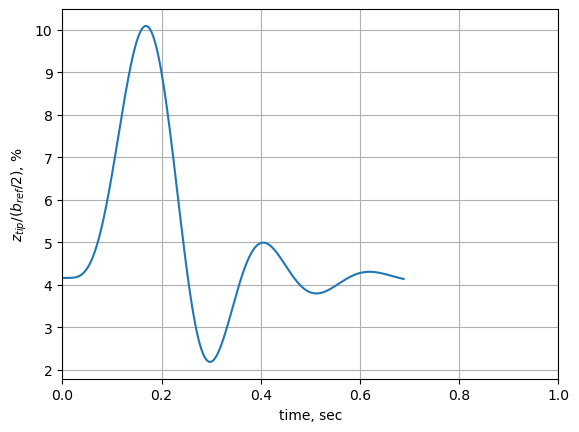

In [10]:
def get_resulting_vertical_tip_displacement(output_folder, model):    
    file_results = os.path.join(output_folder, 
                                 model.case_name, 
                                 'WriteVariablesTime',
                                 'struct_pos_node{}.dat'.format(model.num_node_surf))
    vertical_tip_displacement = np.loadtxt(file_results)[:,-1]
    
                                             
    return vertical_tip_displacement


tip_displacement_open_loop = get_resulting_vertical_tip_displacement(output_folder, 
                                                                     pazy_model_open_loop)


time_array = np.arange(0, len(tip_displacement_open_loop) * pazy_model_open_loop.dt, pazy_model_open_loop.dt)
normalised_tip_displacement = tip_displacement_open_loop/ (0.5*pazy_model_open_loop.b_ref) #normalise by half wing span
normalised_tip_displacement *=100# cconvert to percentnvert to percent
plt.plot(time_array, normalised_tip_displacement)
plt.xlabel('time, sec')
plt.ylabel('$z_{tip}/(b_{ref}/2)$, %')
plt.xlim([0., simulation_time])
plt.grid()
plt.show()

## Generate linear ROM

We continue with the linearization of the nonlinear aeroelastic model of the Pazy wing at the previous defined operational point and a subsequent reduction of the resulting linear state-space system. The structural and aerodynamic model are linearized and reduced separately, and finally couple both resulting linear systems. Please see [2] for more details. 

### Define Simulation Settings
We can re-use the simulation settings from the open-case with a few exception. Besides the name of course, we need to extend the simulation `flow` list by the solvers needed for the linearization and export of the resulting linear state-space system. Further, we need to change the simulation time as we need to run only on simulation timestep of the `DynamicCoupled` solver before the linearization. Also, no gust encounter is needed as we linarize the model around its equlibirum during steady-flight conditions.

In [11]:
case_name = 'pazy_ROM'

flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        'Modal',
        'LinearAssembler',
        'SaveData',
        ]

simulation_time_ROM = pazy_model_open_loop.dt # only one timestep has to be performed
gust = False

We further need to define the method used to reduce the linearized aerodynamic model. Here, we are going to apply a Krylov-based model order reduction scheme for the aerodynamic system, see [4] for more information. Please note that this is only one of the reduction methods implemented in SHARPy. Checkout LINK for the implemented alternative methods.

In [12]:
use_rom = True
rom_settings = {
    'use': use_rom,
    'rom_method': 'Krylov',
    'rom_method_settings': {'Krylov': {
                                        'algorithm': 'mimo_rational_arnoldi',
                                        'r': 4, 
                                        'frequency': np.array([0]),
                                        'single_side': 'observability',
                                        },
                           }
                }

The linearised structural model is 

In [13]:
num_modes = 20


In [14]:
unsteady_force_distribution = False

In [15]:
remove_gust_input_in_statespace = False

### Generate Input Files

In [16]:
pazy_model_ROM = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time_ROM,)

generate_aero_and_fem_input_files(pazy_model_ROM)


In [17]:
pazy_model_ROM.set_default_config_dict()
pazy_model_ROM.config = get_settings_udp(pazy_model_ROM,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            num_modes = num_modes,
                            rom_settings = rom_settings,
                            remove_gust_input_in_statespace=remove_gust_input_in_statespace,
                            unsteady_force_distribution=unsteady_force_distribution)
pazy_model_ROM.config.write()

### Run SHARPy Simulation

In [19]:
# TODO: Delete Output Folder
sharpy.sharpy_main.main(['', pazy_model_ROM.route + pazy_model_ROM.case_name + '.sharpy'])

fatal: not a git repository (or any of the parent directories): .git


 computing lumped masses
 computing lumped masses


/home/sduess/anaconda3/envs/sharpy/lib/python3.10/site-packages/sharpy/linear/src/lingebm.py:313: UserWarning: Euler parametrisation not implemented - Either rigid body modes are not being used or this method has already been called.
  warnings.warn('Euler parametrisation not implemented - Either rigid body modes are not being used or this '


### Prepare Linear System for specific Controller
An overview about the generated linear ROM can be found near the end of the log-file, including number of states, inputs, and outputs as well as the indices mapped to each parameter. The saved linear ROM contains several unused input and output variables. 

We start with reading the matrices from the h5 file and get rid of all unused input and output variables that are not needed for the control design. More precisely, we keep the gust and control surface inputs as well as the vertical tip displacements as an outputs. 

delta and delta dog

Subsequently, we simulate the open-loop and closed-loop responses for different proportional gains of the P-controller.

First, we save some parameters needed for this to a dict 

In [21]:
folder_linear_results =os.path.join(output_folder, pazy_model_ROM.case_name,'linear_results')
if not os.path.exists(folder_linear_results):
    os.makedirs(folder_linear_results)
    
import scipy.io

parameter_matlab = {'num_aero_states': 80, # see log file
                    'num_modes': 20,  # see log file
                     'u_inf': float(pazy_model_ROM.u_inf),
                    'simulation_time': simulation_time,
                    'gust_length': float(gust_settings['gust_length']),
                    'gust_intensity': float(gust_settings['gust_intensity']),
                    'num_control_surfaces': num_control_surfaces,
                    'n_nodes': number_spanwise_nodes,
                    'control_input_start': 193 + 1, # see log file and + 1 for matlab indices
                    'gust_input_start': 192 + 1 , # see log file and + 1 for matlab indices
                   }

scipy.io.savemat(os.path.join(folder_linear_results, 'simulation_parameters.mat'), parameter_matlab)

Next, we open Matlab and run the script *control_design_script.m* from the path

In [22]:
route_notebook_dir

'/home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control'

which runs the linear open-loop gust response of this problem as well as two linear closed-loop gust response using a P-controller with two different gain values. This P-controller is using the deviation of the vertical tip displacement to its reference condition as an error function. Finally, the script is saving the results as txt-files in your output folder and to which we are taking a closer look next.

### Postprocessing
Now, let us have a look at the linear results generated:

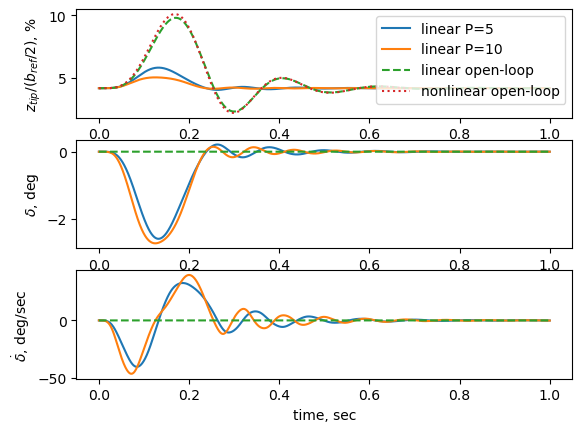

In [24]:
# Load linear results
tip_deflection_linear = np.loadtxt(folder_linear_results + '/tip_deflection.txt', delimiter = ',')
time_array_linear = np.loadtxt(folder_linear_results + '/time_array_linear.txt', delimiter = ',')
normalised_tip_deflection_linear = tip_deflection_linear / (0.5 *pazy_model_ROM.b_ref) * 100
control_surface_deflection_deg = np.loadtxt(folder_linear_results + '/deflection.txt', delimiter = ',')
control_surface_deflection_rate_deg = np.loadtxt(folder_linear_results + '/deflection_rate.txt', delimiter = ',')

# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '-', '--', ':']
list_labels = ['linear P=5', 'linear P=10', 'linear open-loop', 'nonlinear open-loop']
for i in range(3):
    axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,i], list_linestyles[i], label=list_labels[i])

axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])
axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')

for i in range(3):
    axs[1].plot(time_array_linear, control_surface_deflection_deg[:,i], list_linestyles[i])
    
axs[1].set(ylabel='$\delta$, deg')
for i in range(3):
    axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,i], list_linestyles[i])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')


We see

## Closed-Loop Nonlinear Gust Response

In [25]:
case_name = 'pazy_udp_closed_loop_gust_response'
gust = True
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        ]

In [26]:
initial_cs_deflection = 0
cs_type = 2 

In [27]:
pazy_model_closed = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      initial_cs_deflection=initial_cs_deflection,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,
                                      cs_type=cs_type)
generate_aero_and_fem_input_files(pazy_model_closed)

In [33]:
#  Network settings for nonlinear in closed-loop simulations   
server_ip_addr = '127.0.0.1' # SHARPy
client_ip_addr = '127.0.0.1' # controller
port_in_network = 64017
port_out_network_server = 59017
port_out_network_client = 59007   
network_settings = {'variables_filename': route_notebook_dir + '/pazy_network_info.yml', # TODO: explain in text, write yml file depending on number of spanwise nodes
                                        'send_output_to_all_clients': False,
                                        'byte_ordering': 'little',
                                        'log_name': output_folder +'/'+ case_name + '/sharpy_network.log',
                                        'file_log_level': 'debug',
                                        'console_log_level': 'error',
                                        'input_network_settings': {'address': server_ip_addr,
                                                                        'port': port_in_network,
                                                                        },
                                        'output_network_settings': {'send_on_demand': False,
                                                                        'port': port_out_network_server,
                                                                        'address':server_ip_addr, 
                                                                        'destination_address': [client_ip_addr],
                                                                        'destination_ports': [port_out_network_client],
                                                                }
                                                }



In [34]:
num_sensors = 1

In [35]:
pazy_model_closed.set_default_config_dict()
pazy_model_closed.config = get_settings_udp(pazy_model_closed,
                            flow,
                            network_settings=network_settings,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            write_screen = False)
pazy_model_closed.config.write()

Start simulation and controller and UDP-interface,
write necessary parameters to file

In [37]:

dict_parameters = {"server_ip_addr": server_ip_addr,
                   "client_ip_addr": client_ip_addr,
                   "port_in_network": port_in_network,
                   "port_out_network_server": port_out_network_server,
                   "port_out_network_client": port_out_network_client,
                   "output_folder": os.path.abspath(output_folder),
                   "dt": pazy_model_closed.dt,
                   "simulation_time": simulation_time,
                   "num_sensors": num_sensors,
                   "initial_cs_deflection": initial_cs_deflection,
                   "reference_deflection": tip_displacement_open_loop[0],
                  }
with open('./parameter_UDP_control_{}.json'.format(pazy_model_closed.case_name), 'w') as fp:
    json.dump(dict_parameters, fp)

In [38]:
sharpy.sharpy_main.main(['', pazy_model_closed.route + pazy_model_closed.case_name + '.sharpy']);

fatal: not a git repository (or any of the parent directories): .git


KeyboardInterrupt: 

## Final Postprocessing

In [46]:
control_surface_input = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_control_input"))
delta_dot = np.diff(np.rad2deg(control_surface_input))/pazy_model_closed.dt
tip_displacement_nonlinear_P10 = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_sensor_measurement"))
time_array_nonlinear_closed_loop = np.arange(0, len(tip_displacement_nonlinear_P10) * pazy_model_closed.dt, pazy_model_closed.dt)
tip_displacement_nonlinear_P10 /= pazy_model_closed.b_ref/2
tip_displacement_nonlinear_P10 *= 100

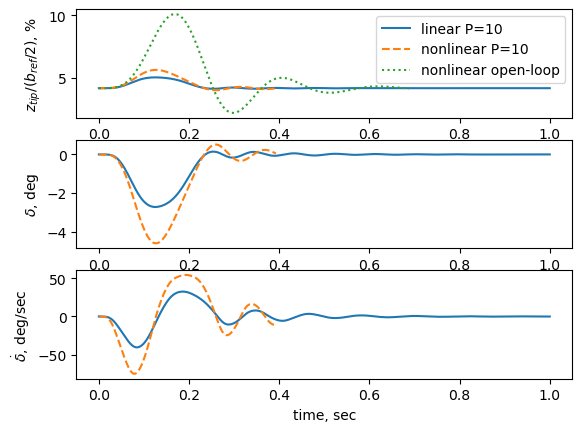

In [47]:
# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '--', ':']
list_labels = ['linear P=10', 'nonlinear P=10', 'nonlinear open-loop']
axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,1], list_linestyles[0], label=list_labels[0])
axs[0].plot(time_array_nonlinear_closed_loop, 
            tip_displacement_nonlinear_P10, 
            list_linestyles[1], 
            label=list_labels[1])
axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])

axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')


axs[1].plot(time_array_linear, control_surface_deflection_deg[:,1], list_linestyles[0])
axs[1].plot(time_array_nonlinear_closed_loop, np.rad2deg(control_surface_input), list_linestyles[1])
    
axs[1].set(ylabel='$\delta$, deg')

axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,0], list_linestyles[0])
axs[2].plot(time_array_nonlinear_closed_loop[1:], 
            delta_dot, 
            list_linestyles[1])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')